# Deep Learning


In [ ]:
# following packages have to be re-installed for every new session in Google colab

In [2]:
!pip install --upgrade pip
!pip install torchinfo
!pip install pytorch_lightning
!pip install islp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 164.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 181.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression,LogisticRegression,Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split,GridSearchCV)

### Torch-Specific Imports


In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [3]:
from torchmetrics import (MeanAbsoluteError,R2Score)
from torchinfo import summary

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [5]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

INFO:lightning_fabric.utilities.seed:Seed set to 0


In [6]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop,ToTensor)

In [7]:
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)
from glob import glob
import json

## IMDB Document Classification


#### Binary Sentiment Classification Model

In [8]:
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]


Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

#### dataset shape

In [9]:
print("Train dataset shape:", imdb_seq_train.tensors[0].shape)
print("Test dataset shape:", imdb_seq_test.tensors[0].shape)



Train dataset shape: torch.Size([25000, 500])
Test dataset shape: torch.Size([25000, 500])


In [10]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

#### check index-word mapper

In [11]:
list(lookup.items())[:10] # vacabrary dict: indexed in squence of frequency of the words in the corpus  #Q1

[(34704, 'fawn'),
 (52009, 'tsukino'),
 (52010, 'nunnery'),
 (16819, 'sonja'),
 (63954, 'vani'),
 (1411, 'woods'),
 (16118, 'spiders'),
 (2348, 'hanging'),
 (2292, 'woody'),
 (52011, 'trawling')]

#### view the first review

In [12]:
imdb_seq_train.tensors[1][0]


tensor(1.)

In [13]:
first_review = imdb_seq_train.tensors[0][0]   # feature vector of the first review  #Q2
first_label = imdb_seq_train.tensors[1][0]    # label of the first review (0: negative, 1: positive) --> so supervised learning

active_word_indices = torch.nonzero(first_review).squeeze()

print("Label of the first review (0=negative, 1=positive):", first_label.item())
print("Active word indices in the review:", active_word_indices.tolist())


Label of the first review (0=negative, 1=positive): 1.0
Active word indices in the review: [282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463

#### Convert word indices to actual words using lookup

In [14]:
lookup = load_lookup(root='data/IMDB')
active_words = [lookup[idx.item()] for idx in active_word_indices]

print("Words appearing in the first review:")
print(active_words)

Words appearing in the first review:
['reason', 'true', 'actor', 'everything', "wasn't", 'shows', 'dvd', 'three', 'worth', 'year', 'job', 'main', 'someone', 'together', 'watched', 'play', 'american', 'plays', '1', 'said', 'effects', 'later', 'takes', 'instead', 'seem', 'beautiful', 'john', 'himself', 'version', 'audience', 'high', 'house', 'night', 'during', 'everyone', 'left', 'special', 'seeing', 'half', 'excellent', 'wife', 'star', 'shot', 'war', 'idea', 'nice', 'black', 'less', 'mind', 'simply', 'read', 'second', 'else', "you're", 'father', 'fan', 'poor', 'help', 'completely', 'death', '3', 'used', 'home', 'either', 'short', 'line', 'given', 'men', 'top', 'dead', 'budget', 'try', 'performances', 'wrong', 'classic', 'boring', 'enjoy', 'need', 'rest', 'use', 'kids', 'hollywood', 'low', 'production', 'until', 'along', 'full', 'friends', 'camera', 'truly', 'women', 'awful', 'video', 'next', 'tell', 'remember', 'couple', 'stupid', 'start', 'stars', 'perhaps', 'sex', 'mean', 'came', 'rec

In [15]:
imdb_seq_train.tensors[0][0].shape # 3 addition for extra tokens to handle biases : 1:<PAD>, 2<START>, 3<UNK> (Unknown word) #Q3

torch.Size([500])

In [16]:
print("Index 0:", lookup[0])
print("Index 1:", lookup[1])
print("Index 2:", lookup[2])

Index 0: <PAD>
Index 1: <START>
Index 2: <UNK>


In [17]:
max_num_workers=10
(imdb_train,
 imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)


Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [18]:
class IMDBModel(nn.Module):   #Q4

    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)


In [19]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return F.linear(input, self.weight, self.bias)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [20]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)


In [21]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=False, #changed to False for latest cuda's default setting
                       max_epochs=10, #reduced 30 to 10 (note: accuracy remains similar but test loss doubled)
                       logger=imdb_logger,
                       enable_progress_bar=True,
                       callbacks=[ErrorTracker()],
                       log_every_n_steps=10)
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [44]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8652399778366089     │
│         test_loss         │    0.46127235889434814    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.46127235889434814, 'test_accuracy': 0.8652399778366089}]

### Comparison to Lasso


In [45]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000, ## separate 2000 records (from 25,000) as validation set
                                 random_state=0,
                                 root='data/IMDB')


In [46]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))


In [47]:
logit = LogisticRegression(penalty='l1',
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)


In [48]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)



In [50]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)


In [51]:
from sklearn.metrics import accuracy_score
y_pred = logit.predict(X_test)
test_accuracy = accuracy_score(Y_test, y_pred)
print(f"Test accuracy (Lasso): {test_accuracy:.4f}")

from sklearn.metrics import log_loss
test_loss = log_loss(Y_test, logit.predict_proba(X_test))
print(f"Test loss (Lasso): {test_loss:.4f}")


Test accuracy (Lasso): 0.8458
Test loss (Lasso): 0.8219


In [52]:
%%capture
fig, axes = subplots(1, 2, figsize=(12, 4), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)



In [53]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='*',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

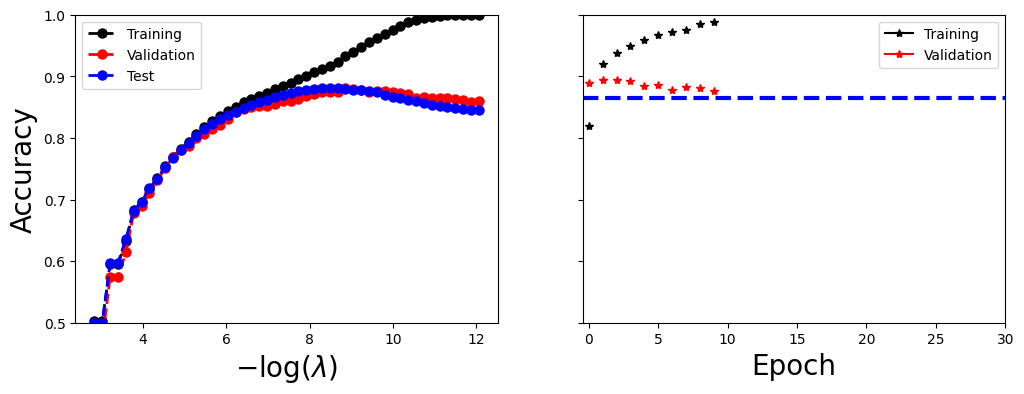

In [54]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

In [ ]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

## Recurrent Neural Networks


### LSTM sentiment prediction to the IMDb movie-review data, as discussed in Section


In [55]:
max_num_workers=10
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers)
                               )


In [56]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True)
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))


In [57]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [58]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')


In [59]:
lstm_trainer = Trainer(deterministic=False, # for cuda setting
                       max_epochs=10,  # reduced the max epoch from 20 to 10 for testing (accuarcy similar, loss is even better)
                       logger=lstm_logger,
                       enable_progress_bar=True,
                       callbacks=[ErrorTracker()])
lstm_module.train() # to meet cuda's default
lstm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8283200263977051     │
│         test_loss         │    0.5928847789764404     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5928847789764404, 'test_accuracy': 0.8283200263977051}]

(0.5, 1.0)

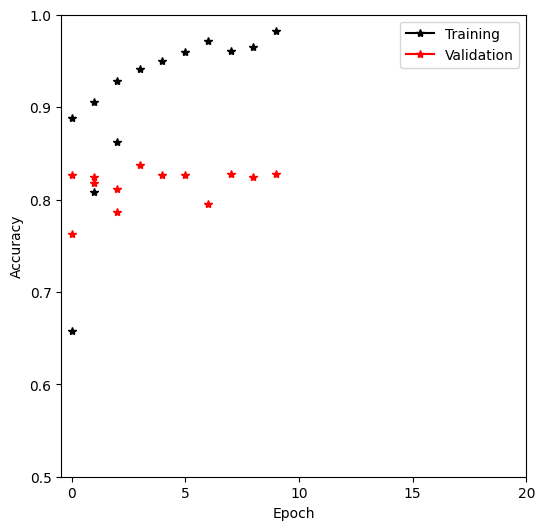

In [ ]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])


In [ ]:
del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)


### Time Series Prediction


In [62]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                     with_mean=True,
                     with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)


In [63]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()


In [64]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns


Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [65]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [66]:
X_day = pd.concat([X,
                  pd.get_dummies(NYSE['day_of_week'])],
                  axis=1).dropna()

In [ ]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053274

In [67]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns


Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [68]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [69]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [70]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y.values[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets


In [71]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [73]:
max_num_workers=10
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

In [74]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [75]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})


In [76]:
nyse_trainer = Trainer(deterministic=False, # changed to False; results will not be fixed
                       max_epochs=20, # reduced max epoch from 200 to 20 for a stable testing on cpu
                       enable_progress_bar=True,
                       gradient_clip_val=1.0, # added to avoid exploding gradient
                       callbacks=[ErrorTracker()])
nyse_module.train()
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6379556655883789     │
│          test_r2          │    0.3945489525794983     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6379556655883789, 'test_r2': 0.3945489525794983}]

In [77]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                   np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [78]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)


In [79]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))


In [80]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                           lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                        optimizer=nl_optimizer,
                                        metrics={'r2':R2Score()})


In [81]:
nl_trainer = Trainer(deterministic=False, # changed
                     max_epochs=10, # max epoch reduced from 20 to 10
                     enable_progress_bar=True,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5665395855903625     │
│          test_r2          │    0.4623262882232666     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5665395855903625, 'test_r2': 0.4623262882232666}]